<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Выборки" data-toc-modified-id="Выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выборки</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [1]:
import pandas as pd
import spacy
from collections import namedtuple

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

from catboost import Pool, CatBoostClassifier

In [2]:
STATE = sum(ord(x) for x in 'NEVER SURRENDER')
SAMPLE_SIZE = 27_000

_____________________
Загрузим данные:

In [3]:
df_text = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0])
df_text.info()
df_text.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


In [4]:
df_text.duplicated().sum()

0

Посмотрим распределение целевого признака `toxic`

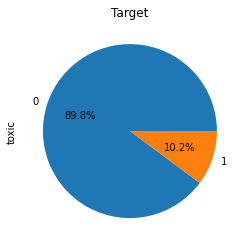

In [5]:
df_text['toxic'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Target');

Можно обратить внимание, что целевой признак не сбалансирован, что стоит учитывать при построении моделей.
__________________________

Проведем минимальную обработку текста:
- оставим только английские буквы и апостраф. Он часто используется в английской речи для сокращения слов и часто учитывается в словарях. 
- удалим лишние проблемы и приведем все к нижнему регистру

In [6]:
%%time
df_text['text'] = df_text['text'].str.replace(r'[^A-Za-z\']',' ', regex=True).str.lower().str.strip()
df_text['text'] = df_text['text'].str.replace(r'\W{2,}',' ', regex=True)

CPU times: user 5.49 s, sys: 169 ms, total: 5.66 s
Wall time: 5.67 s


После удаления "мусора" из текста проверим еще раз на дубликаты.

In [7]:
df_text.duplicated().sum()

1264

Появились дубликаты, удалим их

In [8]:
df_text = df_text.drop_duplicates().reset_index(drop=True)

При помощи `spaCy` проведем лемматизацию и удалим стоп-слова. 

Результат сохраним в отдельный файл, который будем загружать при необходимости.

In [9]:
%%time
try:
    clear_text = pd.read_csv('clear_data.csv', index_col=[0])
except:
    ##30 min
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    #lemma and clear stop 
    clear_text = df_text['text'].apply(lambda row: ' '.join([w.lemma_ for w in nlp(row) if not w.is_stop]))
    pd.DataFrame(clear_text).to_csv('clear_data.csv')

df_text['clear_text'] = clear_text
df_text.loc[df_text['clear_text'].isna(), 'clear_text'] = ''

CPU times: user 409 ms, sys: 67.7 ms, total: 477 ms
Wall time: 812 ms


**Вывод:** данные предварительно изучены, выявлен дисбаланс классов в целевом признаке. Проведена предварительная обработка текста.

## Выборки

**Используемая функция**

In [10]:
def create_train_data(data: pd.DataFrame, 
                      balance: bool, 
                      sam_size: int = SAMPLE_SIZE, 
                      state_: int = STATE) -> namedtuple:
    
    #create namedtuples
    result = namedtuple(f'train_data_{"balanced" if balance else "imbalanced"}', 
                        'clear , raw, tf_idf, target, tf_idf_fit')
    
    #sample
    if balance:
        #balansed downsample
        data = (data.groupby('toxic', group_keys= False) 
                    .apply(lambda x: x.sample(n=SAMPLE_SIZE//2, random_state=STATE))
                    .sample(frac=1, random_state=STATE).reset_index(drop=True))  
    else:
        #imbalanced
        data = data.sample(n=SAMPLE_SIZE, random_state=STATE).reset_index(drop=True)

        
    #save tf_idf_fit for transform test data
    result.tf_idf_fit = TfidfVectorizer().fit(data['clear_text'].values) 
   
    #tf_idf_transform
    result.tf_idf = result.tf_idf_fit.transform(data['clear_text'].values)
    
    #data to namedtuple
    result.clear = data['clear_text']
    result.raw = data['text']
    result.target = data['toxic']
    
    return result


__________________________________
Данных достаточно много и их обработка может занимать много времени и ресурсов. Предположим, что для достижения целевой метрики F1 > 0.75 достаточно около 30 000 записей для обучающей выборки.

Выборки будут созданы по принципу:
- сбалансированная (добавлена в основном для учебных целей)
- несбалансированная

Разные модели могут требовать разные типы входных данных. Соответственно, каждая из выборок будет содержать
- tf_idf таблица
- текст до лемматизации (для CatBoost)
- текст после лемматизации (для CatBoost) 
- отдельно BERT таблица

In [11]:
data_dict = {}
test_dict = {}

Отделим часть в тестовую выборку.


In [12]:
train, test_data = train_test_split(df_text, test_size=0.15, 
                                    stratify=df_text['toxic'], random_state=STATE)

In [13]:
train['toxic'].value_counts()

0    120666
1     13657
Name: toxic, dtype: int64

In [14]:
%%time
data_dict['balance'] = create_train_data(train, True)
data_dict['imbalance'] = create_train_data(train, False)

CPU times: user 2.93 s, sys: 7.07 ms, total: 2.94 s
Wall time: 2.95 s


______________
Bert

In [15]:
## BERT был сделан отдельно и результат загружен в виде csv
for name in ['imbalance_bert', 'balance_bert']:
    try:
        data = pd.read_csv(f'{name}.csv', index_col=[0]).drop('Unnamed: 0.1', axis=1)
        print(f'Load {name}')
        display(data.head())
        #create nametuples
        bert = namedtuple(name, 'features, target')
        bert_test = namedtuple(name, 'features, target')
        #split
        bert.features, bert_test.features, bert.target, bert_test.target = train_test_split(data.drop('toxic', axis=1),
                                                                                            data['toxic'],
                                                                                            train_size=.8,
                                                                                            random_state=STATE, 
                                                                                            stratify=data['toxic'])
        
        data_dict[name] = bert
        test_dict[name] = bert_test
    except:
        print(f'No file {name}')

Load imbalance_bert


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
0,0.040551,0.098047,0.003993,-0.089149,-0.024042,-0.209451,0.056575,0.530667,-0.363835,-0.080911,...,-0.160681,0.139658,0.004027,0.168727,0.206579,-0.098264,0.047215,0.430849,0.310083,0
1,0.230540,0.078137,0.246056,-0.088148,-0.027989,-0.218337,0.234127,0.414366,-0.141701,-0.289833,...,-0.064243,-0.098615,-0.294578,0.185810,0.015010,-0.113231,0.067544,0.526974,0.403077,0
2,-0.249740,0.023389,-0.127600,-0.076919,0.034111,-0.372057,0.224738,0.473094,-0.078764,-0.407230,...,-0.130349,0.131835,-0.272085,0.285550,0.069258,-0.355054,0.114961,0.437836,0.586909,0
3,0.124559,0.091973,0.001655,-0.197695,-0.023416,-0.218565,0.094834,0.307595,-0.108520,-0.117116,...,-0.070422,0.021249,-0.190425,0.229035,0.136221,-0.193482,0.069627,0.467001,0.181009,0
4,-0.075406,0.011700,0.078155,-0.296333,-0.203499,-0.066793,0.339146,0.503677,-0.186039,-0.150082,...,-0.390595,0.014569,-0.106426,0.223465,0.015653,-0.194121,-0.114709,0.371811,0.282532,0


Load balance_bert


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,toxic
0,0.040551,0.098047,0.003993,-0.089149,-0.024042,-0.209451,0.056575,0.530667,-0.363835,-0.080911,...,-0.160681,0.139658,0.004027,0.168727,0.206579,-0.098264,0.047215,0.430849,0.310083,1
1,0.230540,0.078137,0.246056,-0.088148,-0.027989,-0.218337,0.234127,0.414366,-0.141701,-0.289833,...,-0.064243,-0.098615,-0.294578,0.185810,0.015010,-0.113231,0.067544,0.526974,0.403077,1
2,-0.249740,0.023389,-0.127600,-0.076919,0.034111,-0.372057,0.224738,0.473094,-0.078764,-0.407230,...,-0.130349,0.131835,-0.272085,0.285550,0.069258,-0.355054,0.114961,0.437836,0.586909,0
3,0.124559,0.091973,0.001655,-0.197695,-0.023416,-0.218565,0.094834,0.307595,-0.108520,-0.117116,...,-0.070422,0.021249,-0.190425,0.229035,0.136221,-0.193482,0.069627,0.467001,0.181009,1
4,-0.075406,0.011700,0.078155,-0.296333,-0.203499,-0.066793,0.339146,0.503677,-0.186039,-0.150082,...,-0.390595,0.014569,-0.106426,0.223465,0.015653,-0.194121,-0.114709,0.371811,0.282532,1


В итоге были получены выборки:

In [16]:
data_dict

{'balance': __main__.train_data_balanced,
 'imbalance': __main__.train_data_imbalanced,
 'imbalance_bert': __main__.imbalance_bert,
 'balance_bert': __main__.balance_bert}

Так же проверим соотношение целевого признака в несбалансированной выборке:

In [17]:
data_dict['imbalance'].target.value_counts(normalize=True)

0    0.898519
1    0.101481
Name: toxic, dtype: float64

**Вывод** Были созданы сбалансированная и несбалансированная выборки для обучения моделей. Для обучения разных моделей были созданы
- таблица tf_idf 
- таблица BERT
- оставлены тестовые данные

## Обучение

**Используемые функции**

In [18]:
def create_model(model,
                 data_name: str,
                 data_type: str, 
                 parametrs: dict = {},
                 scoring_: str = 'f1') -> list: 
    #get features     
    try:
        if data_type == 'bert':
            data = data_dict[f'{data_name}_bert']
            features = data.features
        else:
            data = data_dict[data_name]
            features = data.clear
            #create Pipeline and update params
            model = Pipeline([('preprocess', TfidfVectorizer()),
                              ('model', model)])
            
            parametrs = {f'model__{key}':value for key,value in parametrs.items()}
            
    except:
        print('Wrong data')
        return ['No data']
    
    #use GridSearchCV
    grid = GridSearchCV(model, parametrs, cv=3, scoring=scoring_)
    grid.fit(features, data.target)
    
    return [grid.best_estimator_,
            grid.best_params_,
            data_name, 
            data_type, 
            round(abs(grid.best_score_),4)]
    

In [19]:
def cat_boost_text(data_name: str,
                   data_type: str, 
                   parametrs: dict) -> list: 
    
    #get features     
    try:
        data = data_dict[data_name]
        features = eval(f'data.{data_type}')
    except:
        print('Wrong data')
        return ['No data']
    
    train_pool = Pool(features, 
                      data.target, 
                      text_features=['text'],
                      feature_names=['text'])    
    model = CatBoostClassifier(**parametrs)
    model.fit(train_pool)
    return [model,
            parametrs,
            data_name, 
            data_type, 
            round(model.best_score_['learn']['F1'], 4)]
    

_____________________
Будем использовать следующие модели:
- LogisticRegression
- CatBoost

Для каждой из моделей зададим минимальный набор гиперпараметров, для экономии времени.

In [20]:
models = []

____________________________
**LogisticRegression**

In [21]:
%%time
lr_params = {'solver': ['lbfgs', 'liblinear'], 
             'class_weight': ['balanced', None], 
             'max_iter': [1000]}
# bert imbalance
models.append(create_model(LogisticRegression(random_state=STATE), 
                           'imbalance', 'bert', parametrs=lr_params))

CPU times: user 2min 7s, sys: 1min 19s, total: 3min 26s
Wall time: 3min 27s


In [22]:
%%time
# bert balance
models.append(create_model(LogisticRegression(random_state=STATE), 
                           'balance', 'bert', parametrs=lr_params))

CPU times: user 1min 28s, sys: 56.2 s, total: 2min 24s
Wall time: 2min 25s


In [23]:
%%time
lr_params['C'] = [7,10]
# tf-idf imbalance
models.append(create_model(LogisticRegression(random_state=STATE), 
                           'imbalance', 'tf_idf', parametrs=lr_params))

CPU times: user 2min 6s, sys: 2min 43s, total: 4min 50s
Wall time: 4min 50s


In [24]:
%%time
# tf-idf balance
models.append(create_model(LogisticRegression(random_state=STATE), 
                           'balance', 'tf_idf', parametrs=lr_params))

CPU times: user 2min 29s, sys: 3min 27s, total: 5min 56s
Wall time: 5min 57s


**CatBoost**

In [25]:
%%time
# bert imbalance
cbc_params = {'learning_rate': [0.4], 
              'iterations': [50, 100],
              'auto_class_weights': ['SqrtBalanced']
             }
models.append(create_model(CatBoostClassifier(random_state=STATE, verbose=100), 
                           'imbalance', 'bert', parametrs=cbc_params))

0:	learn: 0.5988454	total: 417ms	remaining: 20.4s
49:	learn: 0.1403987	total: 11.5s	remaining: 0us
0:	learn: 0.6022384	total: 334ms	remaining: 16.4s
49:	learn: 0.1421541	total: 11.7s	remaining: 0us
0:	learn: 0.6025075	total: 317ms	remaining: 15.5s
49:	learn: 0.1427525	total: 11.3s	remaining: 0us
0:	learn: 0.5988454	total: 355ms	remaining: 35.2s
99:	learn: 0.0329740	total: 22s	remaining: 0us
0:	learn: 0.6022384	total: 315ms	remaining: 31.2s
99:	learn: 0.0317265	total: 21.6s	remaining: 0us
0:	learn: 0.6025075	total: 315ms	remaining: 31.1s
99:	learn: 0.0334699	total: 21.6s	remaining: 0us
0:	learn: 0.6032532	total: 324ms	remaining: 15.9s
49:	learn: 0.2203952	total: 11.5s	remaining: 0us
CPU times: user 1min 53s, sys: 3.27 s, total: 1min 56s
Wall time: 2min 5s


In [26]:
%%time
# bert balance
models.append(create_model(CatBoostClassifier(random_state=STATE, verbose=100), 
                           'balance', 'bert', parametrs=cbc_params))

0:	learn: 0.5076289	total: 326ms	remaining: 16s
49:	learn: 0.0813380	total: 10.9s	remaining: 0us
0:	learn: 0.4998516	total: 315ms	remaining: 15.4s
49:	learn: 0.0896868	total: 11s	remaining: 0us
0:	learn: 0.4908039	total: 313ms	remaining: 15.4s
49:	learn: 0.0776461	total: 11s	remaining: 0us
0:	learn: 0.5076289	total: 322ms	remaining: 31.9s
99:	learn: 0.0234733	total: 22.3s	remaining: 0us
0:	learn: 0.4998516	total: 341ms	remaining: 33.7s
99:	learn: 0.0241582	total: 22.4s	remaining: 0us
0:	learn: 0.4908039	total: 321ms	remaining: 31.7s
99:	learn: 0.0234062	total: 21.9s	remaining: 0us
0:	learn: 0.4988684	total: 377ms	remaining: 37.3s
99:	learn: 0.0433736	total: 22.6s	remaining: 0us
CPU times: user 2min 4s, sys: 2.8 s, total: 2min 6s
Wall time: 2min 18s


In [27]:
%%time
# tf-idf imbalance
models.append(create_model(CatBoostClassifier(random_state=STATE, verbose=100), 
                           'imbalance', 'tf_idf', parametrs=cbc_params))

0:	learn: 0.5177733	total: 618ms	remaining: 30.3s
49:	learn: 0.2036826	total: 22.2s	remaining: 0us
0:	learn: 0.5239004	total: 631ms	remaining: 30.9s
49:	learn: 0.2087092	total: 21.9s	remaining: 0us
0:	learn: 0.5343412	total: 612ms	remaining: 30s
49:	learn: 0.2124470	total: 22.1s	remaining: 0us
0:	learn: 0.5177733	total: 625ms	remaining: 1m 1s
99:	learn: 0.1468660	total: 44.5s	remaining: 0us
0:	learn: 0.5239004	total: 620ms	remaining: 1m 1s
99:	learn: 0.1515197	total: 44.1s	remaining: 0us
0:	learn: 0.5343412	total: 606ms	remaining: 60s
99:	learn: 0.1536345	total: 43.9s	remaining: 0us
0:	learn: 0.5181536	total: 845ms	remaining: 1m 23s
99:	learn: 0.1680037	total: 1m 1s	remaining: 0us
CPU times: user 4min 37s, sys: 5.75 s, total: 4min 43s
Wall time: 5min 18s


In [28]:
%%time
# tf-idf balance
models.append(create_model(CatBoostClassifier(random_state=STATE, verbose=100), 
                           'balance', 'tf_idf', parametrs=cbc_params))

0:	learn: 0.5801581	total: 559ms	remaining: 27.4s
49:	learn: 0.2855960	total: 21.2s	remaining: 0us
0:	learn: 0.5786360	total: 580ms	remaining: 28.4s
49:	learn: 0.2873224	total: 21.9s	remaining: 0us
0:	learn: 0.5702654	total: 600ms	remaining: 29.4s
49:	learn: 0.2799363	total: 21.9s	remaining: 0us
0:	learn: 0.5801581	total: 677ms	remaining: 1m 6s
99:	learn: 0.2277701	total: 41.8s	remaining: 0us
0:	learn: 0.5786360	total: 567ms	remaining: 56.1s
99:	learn: 0.2310582	total: 41.5s	remaining: 0us
0:	learn: 0.5702654	total: 615ms	remaining: 1m
99:	learn: 0.2254201	total: 41.6s	remaining: 0us
0:	learn: 0.5712043	total: 811ms	remaining: 1m 20s
99:	learn: 0.2368329	total: 56.7s	remaining: 0us
CPU times: user 4min 23s, sys: 5.98 s, total: 4min 29s
Wall time: 4min 33s


_________________________________
CatBoots с текстовыми признаками

In [29]:
cbc_text_params = {'random_state' : STATE,
                   'iterations': 150,
                   'auto_class_weights': 'SqrtBalanced',
                   'learning_rate': 0.4,
                   'eval_metric': 'F1',
                   'verbose': 50}

In [30]:
%%time
# imbalance raw
models.append(cat_boost_text('imbalance','raw', cbc_text_params))

0:	learn: 0.7338679	total: 325ms	remaining: 48.4s
50:	learn: 0.8228270	total: 17s	remaining: 33.1s
100:	learn: 0.8494484	total: 33.2s	remaining: 16.1s
149:	learn: 0.8627179	total: 49s	remaining: 0us
CPU times: user 42.1 s, sys: 9.94 s, total: 52 s
Wall time: 52.7 s


In [31]:
%%time
# balance raw
models.append(cat_boost_text('balance','raw', cbc_text_params))

0:	learn: 0.8615910	total: 344ms	remaining: 51.3s
50:	learn: 0.9056604	total: 16.9s	remaining: 32.8s
100:	learn: 0.9099862	total: 32.7s	remaining: 15.8s
149:	learn: 0.9156968	total: 48.2s	remaining: 0us
CPU times: user 41.6 s, sys: 9.31 s, total: 50.9 s
Wall time: 51.6 s


In [32]:
%%time
# imbalance clear
models.append(cat_boost_text('imbalance','clear', cbc_text_params))

0:	learn: 0.7518712	total: 342ms	remaining: 51s
50:	learn: 0.8163512	total: 16.2s	remaining: 31.4s
100:	learn: 0.8334645	total: 32.2s	remaining: 15.6s
149:	learn: 0.8420816	total: 47.8s	remaining: 0us
CPU times: user 40.8 s, sys: 9.36 s, total: 50.1 s
Wall time: 50.8 s


In [33]:
%%time
# balance clear
models.append(cat_boost_text('balance','clear', cbc_text_params))

0:	learn: 0.8587588	total: 371ms	remaining: 55.2s
50:	learn: 0.8985223	total: 17.3s	remaining: 33.7s
100:	learn: 0.9033203	total: 33.4s	remaining: 16.2s
149:	learn: 0.9062864	total: 48.8s	remaining: 0us
CPU times: user 41.3 s, sys: 9.64 s, total: 51 s
Wall time: 51.6 s


**Вывод**

Были обучены несколько моделей с разными наборами данных. 

In [34]:
result = pd.DataFrame(models, columns=['Model', 'Hyperparams', 'Data Name', 'Data Type', 'F1'])
result

,Model,Hyperparams,Data Name,Data Type,F1
0,"LogisticRegression(class_weight='balanced', ma...","{'class_weight': 'balanced', 'max_iter': 1000,...",imbalance,bert,0.1655
1,"LogisticRegression(max_iter=1000, random_state...","{'class_weight': None, 'max_iter': 1000, 'solv...",balance,bert,0.8929
2,"(TfidfVectorizer(), LogisticRegression(C=7, cl...","{'model__C': 7, 'model__class_weight': 'balanc...",imbalance,tf_idf,0.7356
3,"(TfidfVectorizer(), LogisticRegression(C=7, cl...","{'model__C': 7, 'model__class_weight': 'balanc...",balance,tf_idf,0.8945
4,<catboost.core.CatBoostClassifier object at 0x...,"{'auto_class_weights': 'SqrtBalanced', 'iterat...",imbalance,bert,0.0316
5,<catboost.core.CatBoostClassifier object at 0x...,"{'auto_class_weights': 'SqrtBalanced', 'iterat...",balance,bert,0.8699
6,"(TfidfVectorizer(), <catboost.core.CatBoostCla...","{'model__auto_class_weights': 'SqrtBalanced', ...",imbalance,tf_idf,0.7256
7,"(TfidfVectorizer(), <catboost.core.CatBoostCla...","{'model__auto_class_weights': 'SqrtBalanced', ...",balance,tf_idf,0.8815
8,<catboost.core.CatBoostClassifier object at 0x...,"{'random_state': 1114, 'iterations': 150, 'aut...",imbalance,raw,0.8627
9,<catboost.core.CatBoostClassifier object at 0x...,"{'random_state': 1114, 'iterations': 150, 'aut...",balance,raw,0.9157


Можно сделать выводы:
- несбалансированная BERT показывает совсем слабые результаты
- так же для всех несбалансированных выборок результаты хуже, чем сбалансированные, на тех же моделях
- все сбалансированные модели преодолели необходимый порог в F1 > 0.75 для обучающей выборки
_____________________
Для выбора модели будем учитывать:
- предварительная обработка данных (сложность, время)
- используемая выборка (в исследованиях в сети часто отмечается, что модели, обученные на сбалансированных выборках показывают хороший результат на таких же сбалансированных выборках, на несбалансированных результат значительно хуже и требуется дополнительная калибровка модели)
- минимальный порог F1


Лучший результат показали модели на основе CatBoost c текстовым признаком. Так же только они для несбалансированной выборки преодолели порог в F1 > 0.75

Таким образом, для тестирования берем модель CatBoost, обученную на тексте без лемматизации и несбалансированной выборке.


## Тестирование модели


Проверим модель на тестовых данных:

In [35]:
test_data = test_data.reset_index(drop=True)

In [36]:
final_model = models[8][0]
pred = final_model.predict(Pool(test_data['text'], text_features=[0]))

In [37]:
f1_score(test_data['toxic'], pred)

0.7521877486077964

**Проверка на адекватность** 

In [38]:
dummy_clf = DummyClassifier(strategy="stratified", random_state=STATE)

In [39]:
dummy_clf.fit(data_dict['balance'].raw, data_dict['balance'].target)
dummy_pred = dummy_clf.predict(test_data['text'])

In [40]:
f1_score(test_data['toxic'], dummy_pred)

0.1754731583761345

**Вывод** Выбранная модель прошла проверку на адекватность и метрика F1 на тестовой выборке более 0.75.

## Выводы

1. Загружены и изучены данные, обнаружен дисбаланс целевого признака.


2. Произведена первичная обработка текста (удаление "лишних" символов и пробелов, приведение к нижнему регистру), после чего произведена лемматизация и удаление стоп-слов.


3. Сформированы признаки BERT и tf-idf.


4. Из данных сформированы сбалансированная и несбалансированная выборки


5. Обучены модели
    - LogisticRegression
    - CatBoost
        - на подготовленных признаках
        - на тексте


Была выбрана модель CatBoost, обученная на тексте без лемматизации и несбалансированной выборке, `F1` на тренировочной **0.8627**.

На тестовой выборке модель показала результат в **0.752** => цель достигнута.


Таким образом, можно рекомендовать модель для внедрения.
_____________________________________